# Ensemble Methods Notebook
Welcome to the weekly project on Ensemble Methods. You will be working with a dataset of traffic jams.

## Dataset
The dataset that will be used in this task is `Traffic_Jam.csv`

## Instructions
- Follow the steps outlined below.
- Write your code in the empty code cells.
- Comment on your code to explain your reasoning.

## Dataset Overview
This dataset contains traffic data including various counts of vehicle types across different times and days. Below are samples of these columns:

* `Time`: The timestamp of the traffic count (in intervals).
* `Date`: The day of the month the data was recorded.
* `Day of the Week`: The day of the week for the recorded data.
* `CarCount`: The number of cars counted during the time interval.
* `BikeCount`: The number of bikes counted during the time interval.
* `BusCount`: The number of buses counted during the time interval.
* `TruckCount`: The number of trucks counted during the time interval.
* `Total`: Total vehicles counted during the time interval.
* `Traffic Situation`: Qualitative assessment of the traffic (e.g., normal, congested).

## Goal
The primary goal of this exam is to develop a predictive model capable of determining the `Traffic Situation` based on your choice of features provided in the dataset. Students are expected to apply ensemble methods to build and evaluate their models.

# Import Libraries

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px

from sklearn.ensemble import BaggingClassifier , RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score , confusion_matrix

# Load the dataset


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
df= pd.read_csv('/content/drive/MyDrive/Tuwaiq/Week 3/1-Weekly Task/Datasets/Traffic_Jams.csv')
df.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,13,2,2,24,41,normal
1,12:15:00 AM,10,Tuesday,14,1,1,36,52,normal
2,12:30:00 AM,10,Tuesday,10,2,2,32,46,normal
3,12:45:00 AM,10,Tuesday,10,2,2,36,50,normal
4,1:00:00 AM,10,Tuesday,11,2,1,34,48,normal


# Exploratory Data Analysis (EDA)



In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6324 entries, 0 to 6323
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               6324 non-null   object
 1   Date               6324 non-null   int64 
 2   Day of the week    6324 non-null   object
 3   CarCount           6324 non-null   int64 
 4   BikeCount          6324 non-null   int64 
 5   BusCount           6324 non-null   int64 
 6   TruckCount         6324 non-null   int64 
 7   Total              6324 non-null   int64 
 8   Traffic Situation  6324 non-null   object
dtypes: int64(6), object(3)
memory usage: 444.8+ KB


In [5]:
df.describe()

,Date,CarCount,BikeCount,BusCount,TruckCount,Total
count,6324.000000,6324.000000,6324.000000,6324.000000,6324.000000,6324.000000
mean,16.043327,64.355629,12.013283,12.557875,18.658128,107.584915
std,8.956907,44.307088,11.363955,12.319831,10.724822,55.850784
min,1.000000,5.000000,0.000000,0.000000,0.000000,21.000000
25%,8.000000,18.000000,3.000000,1.000000,10.000000,53.000000
50%,16.000000,61.000000,9.000000,10.000000,18.000000,103.000000
75%,24.000000,101.250000,19.000000,20.000000,27.000000,151.000000
max,31.000000,180.000000,70.000000,50.000000,60.000000,279.000000


# Preprocess the data (if necessary)


In [51]:
df['Time'] = pd.to_datetime(df['Time'])

<ipython-input-51-1bfd8981fe14>:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



## Missing data

In [6]:
df.isnull().sum()

,0
Time,0
Date,0
Day of the week,0
CarCount,0
BikeCount,0
BusCount,0
TruckCount,0
Total,0
Traffic Situation,0


## Outliers

In [7]:
for column in df.columns:
    fig = px.histogram(df, x=column)
    fig.show()

In [52]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers(df, 'BikeCount')
df = remove_outliers(df, 'TruckCount')

In [9]:
df.shape

(6188, 9)

## Drop unnecessary columns

In [37]:
grouped_df = df.groupby(['Date', 'Traffic Situation']).size().reset_index(name='count')
grouped_df


fig = px.bar(grouped_df, x='Date', y='count', color='Traffic Situation', barmode='group', title='Accident Severity by Age')

fig.update_layout(
    xaxis_title='Collision Type',
    yaxis_title='Accident Count'
)

fig.show()

In [53]:
# Date has no relation with Traffic Situation , Traffic conditions are almost the same on every date.
df.drop('Date', axis=1 , inplace= True)


## Feature engneering

In [54]:
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')
df['hour'] = df['Time'].dt.hour
df['minute'] = df['Time'].dt.minute

In [57]:
df.head()

,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation,hour,minute
0,Tuesday,13,2,2,24,41,normal,0,0
1,Tuesday,14,1,1,36,52,normal,0,15
2,Tuesday,10,2,2,32,46,normal,0,30
3,Tuesday,10,2,2,36,50,normal,0,45
4,Tuesday,11,2,1,34,48,normal,1,0


# Visualize the Data


In [29]:
df.head()

,Time,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,2024-08-11 00:00:00,Tuesday,13,2,2,24,41,normal
1,2024-08-11 00:15:00,Tuesday,14,1,1,36,52,normal
2,2024-08-11 00:30:00,Tuesday,10,2,2,32,46,normal
3,2024-08-11 00:45:00,Tuesday,10,2,2,36,50,normal
4,2024-08-11 01:00:00,Tuesday,11,2,1,34,48,normal


In [39]:
target = df['Traffic Situation'].value_counts()
target
fig = px.bar(target, x=target.index, y='count', title='Total count of each Traffic Situation', color_discrete_sequence=['#bf7ecc'])

fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=target.index,
        ticktext=target.index
    )
)
fig.show()

# There is an impalance in the target, i need to solve it

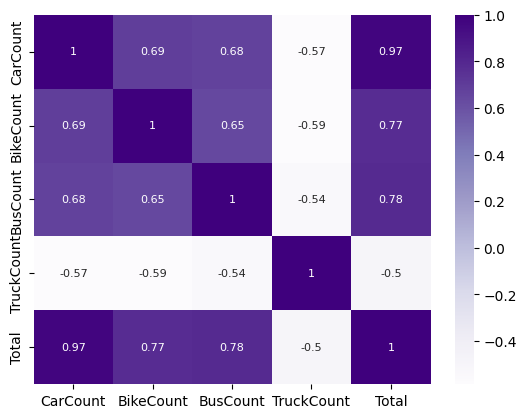

In [40]:
sns.heatmap(df.corr(numeric_only=True), annot=True, annot_kws={'fontsize': 8}, cmap='Purples');


In [93]:
df['Traffic Situation'].value_counts()

,count
Traffic Situation,
normal,3849
heavy,1027
low,834
high,478


**Correlated features**

CarCount - Total

In [58]:
# Drop the total column as it is highly correlated with the number of cars.
df.drop('Total', axis=1 , inplace=True)

The graph below shows the days of the week with heavy traffic, we notice that the heavy traffic on Friday is the least.

In [100]:
filtered = df[df['Traffic Situation'] == 'heavy']

grouped = filtered.groupby('Day of the week')['Traffic Situation'].count()
grouped = grouped.sort_values(ascending=False)


fig = px.bar(grouped, x=grouped.index, y='Traffic Situation', title='Weekdays with heavy traffic', color_discrete_sequence=['#86bfe1'])

fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=grouped.index,
        ticktext=grouped.index
    )
)
fig.show()


# Split the Dataset


In [71]:
from sklearn.model_selection import train_test_split

X = df.drop("Traffic Situation", axis=1)
y = df["Traffic Situation"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Encoding and scalling

In [60]:
df.head()

,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Traffic Situation,hour,minute
0,Tuesday,13,2,2,24,normal,0,0
1,Tuesday,14,1,1,36,normal,0,15
2,Tuesday,10,2,2,32,normal,0,30
3,Tuesday,10,2,2,36,normal,0,45
4,Tuesday,11,2,1,34,normal,1,0


In [84]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

num_pip = make_pipeline(MinMaxScaler())
cat_pip_one_hot = make_pipeline(OneHotEncoder(handle_unknown='ignore'))


pre_pip = ColumnTransformer([
    ('num_scalling', num_pip, ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'hour', 'minute']),
    ('cat_one_hot', cat_pip_one_hot, ['Day of the week']),
    ])

X_train_prepared = pre_pip.fit_transform(X_train)
X_test_prepared = pre_pip.transform(X_test)

# Handling impalance data

In [85]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_prepared, y_train)


# Initialize and Train the Classifiers

## Bagging


In [79]:
base_model = KNeighborsClassifier()

bagging_model = BaggingClassifier(base_model, n_estimators=30, random_state=6)

model = bagging_model.fit(X_train_resampled, y_train_resampled)

### Evaluate the model performance

In [80]:
y_pred = model.predict(X_test_prepared)

accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy * 100:.2f}%')

Model Accuracy: 75.44%


## Boosting


In [87]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')


base_estimator = DecisionTreeClassifier(max_depth=1)
adaboost_classifier = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, random_state=42)

adaboost_classifier.fit(X_train_resampled, y_train_resampled)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   random_state=42)

### Evaluate the model performance

In [88]:
y_pred = adaboost_classifier.predict(X_test_prepared)

accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy * 100:.2f}%')

Model Accuracy: 46.04%


## Stacking Classifier


In [89]:
from sklearn.ensemble import StackingClassifier

base_model = KNeighborsClassifier()

base_models = [
    ('bagging', BaggingClassifier(base_model, n_estimators=30, random_state=6)),
    ('ada', AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, random_state=42))
]


### Define meta-learner (LogisticRegression)

In [91]:
from sklearn.linear_model import LogisticRegression
meta_model = LogisticRegression()

stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

stacking_classifier.fit(X_train_resampled, y_train_resampled)

StackingClassifier(cv=5,
                   estimators=[('bagging',
                                BaggingClassifier(estimator=KNeighborsClassifier(),
                                                  n_estimators=30,
                                                  random_state=6)),
                               ('ada',
                                AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                                   random_state=42))],
                   final_estimator=LogisticRegression())

### Evaluate the model performance

In [92]:
y_pred = stacking_classifier.predict(X_test_prepared)

accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy * 100:.2f}%')

Model Accuracy: 79.24%


# Notebook Questions:

After completing the tasks in this notebook, take some time to reflect on the work you have done and answer the following questions. These questions are designed to help you think critically about the steps you took and the decisions you made.

* **Feature Selection and Engineering**
   - Which features did you find most important for predicting Traffic Situation, and why do you think they are significant?
   - Date column has no relation with Traffic Situation , Traffic conditions are almost the same on every date, so i dropped it , according to other columns, in the subject of Traffic Situation, they absolutely important for the prediction  


   - Did you perform any feature engineering? If so, what new features did you create, and how did they improve the model performance?
   - I did feature engineering on the time column, and extracting the hour and minute because I think these features are important in predicting traffic Situation.

* **Model Selection**
   - Why did you choose the specific ensemble methods you implemented? What are the advantages of using ensemble methods over single models?
   - Ensemble methods produce more accurate results because ensemble methods combine the results of multiple models.


   - Compare the performance of different models you used. Which model performed the best, and what do you think contributed to its success?
   - The best performance is produced by stacking classification, where companies use boosting and bagging as the base model, and use logistic regression as the meta model.

* **Model Evaluation**
   - Which evaluation metrics did you use to assess the model performance, and why? What insights did these metrics provide about the models' strengths and weaknesses?
   - i used accuracy metrics , witch is the most sutable metrics for classification
